Ep 1: Reward=-183.0, Eps=0.990
Ep 2: Reward=-202.0, Eps=0.980
Ep 3: Reward=-259.0, Eps=0.970
Ep 4: Reward=-176.0, Eps=0.961
Ep 5: Reward=-145.0, Eps=0.951
Ep 6: Reward=-145.0, Eps=0.941
Ep 7: Reward=-183.0, Eps=0.932
Ep 8: Reward=-240.0, Eps=0.923
Ep 9: Reward=-126.0, Eps=0.914
Ep 10: Reward=-240.0, Eps=0.904
Ep 11: Reward=-138.0, Eps=0.895
Ep 12: Reward=-240.0, Eps=0.886
Ep 13: Reward=-138.0, Eps=0.878
Ep 14: Reward=-259.0, Eps=0.869
Ep 15: Reward=-202.0, Eps=0.860
Ep 16: Reward=-164.0, Eps=0.851
Ep 17: Reward=-221.0, Eps=0.843
Ep 18: Reward=-145.0, Eps=0.835
Ep 19: Reward=-107.0, Eps=0.826
Ep 20: Reward=-145.0, Eps=0.818
Ep 21: Reward=-43.0, Eps=0.810
Ep 22: Reward=-107.0, Eps=0.802
Ep 23: Reward=-202.0, Eps=0.794
Ep 24: Reward=-126.0, Eps=0.786
Ep 25: Reward=-164.0, Eps=0.778
Ep 26: Reward=-164.0, Eps=0.770
Ep 27: Reward=-107.0, Eps=0.762
Ep 28: Reward=-145.0, Eps=0.755
Ep 29: Reward=-145.0, Eps=0.747
Ep 30: Reward=-164.0, Eps=0.740
Ep 31: Reward=-138.0, Eps=0.732
Ep 32: Reward=-126

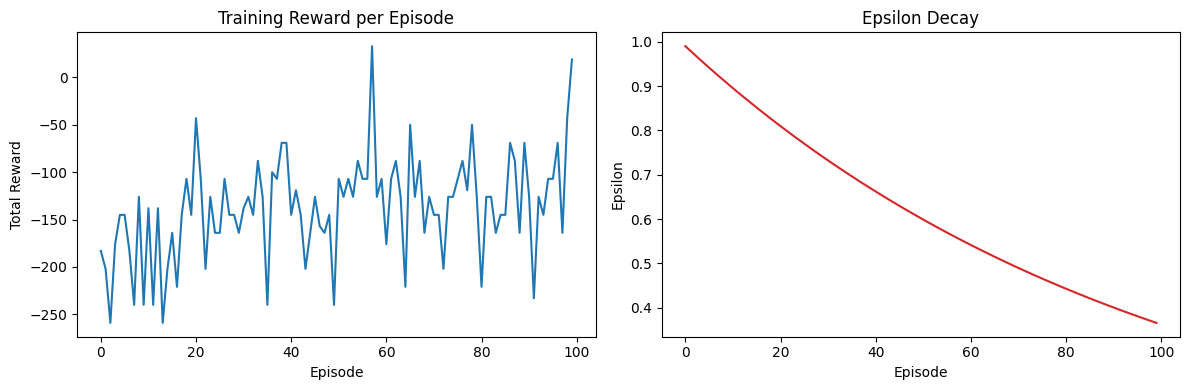

Eval Episode 1: Total Reward = -10
Eval Episode 2: Total Reward = -10
Eval Episode 3: Total Reward = -10
Eval Episode 4: Total Reward = -10
Eval Episode 5: Total Reward = -10
Eval Episode 6: Total Reward = -10
Eval Episode 7: Total Reward = -10
Eval Episode 8: Total Reward = -10
Eval Episode 9: Total Reward = -10
Eval Episode 10: Total Reward = -10
Eval Episode 11: Total Reward = -10
Eval Episode 12: Total Reward = -10
Eval Episode 13: Total Reward = -10
Eval Episode 14: Total Reward = -10
Eval Episode 15: Total Reward = -10
Eval Episode 16: Total Reward = -10
Eval Episode 17: Total Reward = -10
Eval Episode 18: Total Reward = -10
Eval Episode 19: Total Reward = -10
Eval Episode 20: Total Reward = -10
Eval Episode 21: Total Reward = -10
Eval Episode 22: Total Reward = -10
Eval Episode 23: Total Reward = -10
Eval Episode 24: Total Reward = -10
Eval Episode 25: Total Reward = -10
Eval Episode 26: Total Reward = -10
Eval Episode 27: Total Reward = 16
Eval Episode 28: Total Reward = -10
Ev

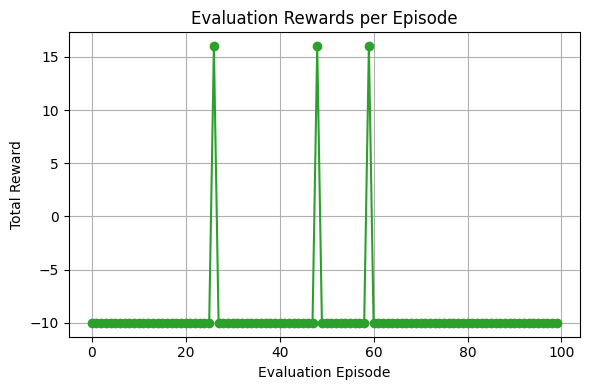


Final Visualized Evaluation:
Step 1: State=(np.float32(0.0), np.float32(0.0), np.float32(0.0)), Action=1, Reward=-1


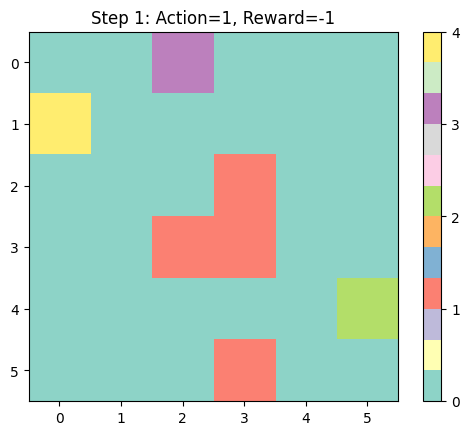

Step 2: State=(np.float32(1.0), np.float32(0.0), np.float32(0.0)), Action=1, Reward=-1


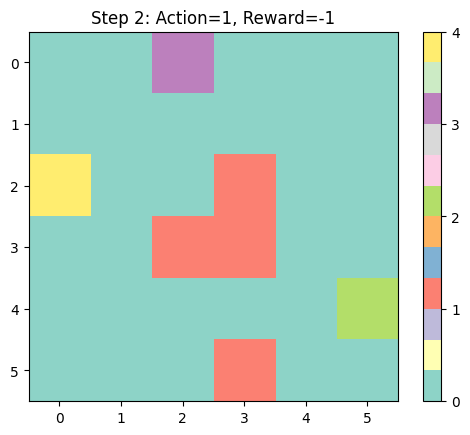

Step 3: State=(np.float32(2.0), np.float32(0.0), np.float32(0.0)), Action=4, Reward=-1


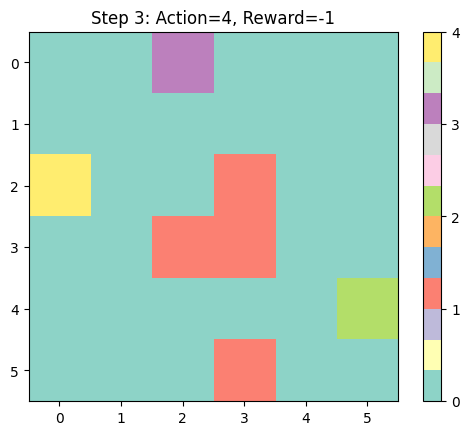

Step 4: State=(np.float32(2.0), np.float32(0.0), np.float32(0.0)), Action=4, Reward=-1


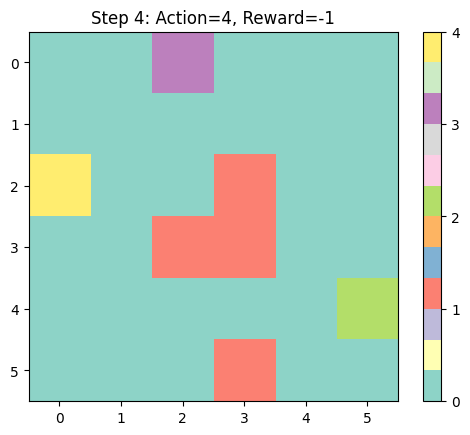

Step 5: State=(np.float32(2.0), np.float32(0.0), np.float32(0.0)), Action=4, Reward=-1


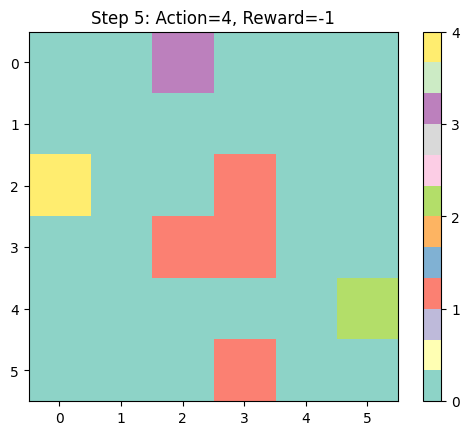

Step 6: State=(np.float32(2.0), np.float32(0.0), np.float32(0.0)), Action=4, Reward=-1


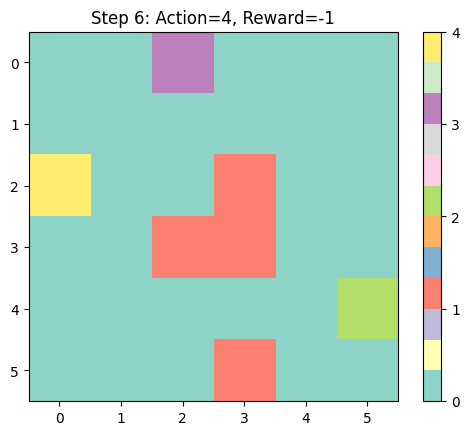

Step 7: State=(np.float32(2.0), np.float32(0.0), np.float32(0.0)), Action=4, Reward=-1


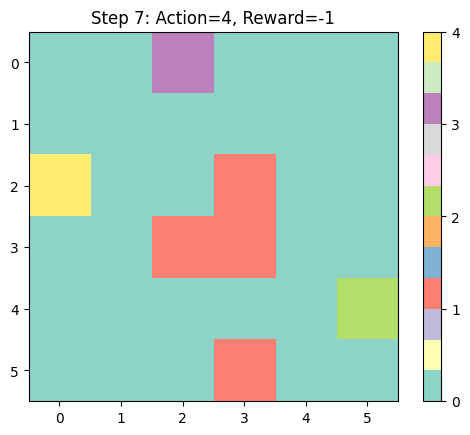

Step 8: State=(np.float32(2.0), np.float32(0.0), np.float32(0.0)), Action=4, Reward=-1


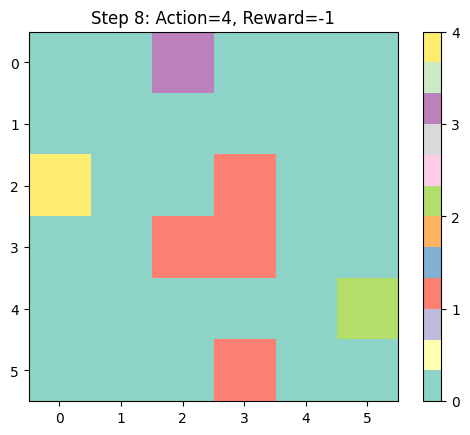

Step 9: State=(np.float32(2.0), np.float32(0.0), np.float32(0.0)), Action=4, Reward=-1


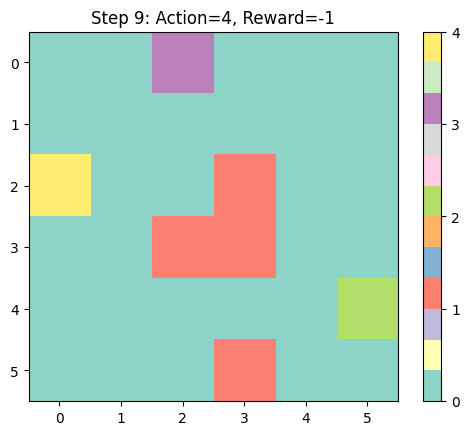

Step 10: State=(np.float32(2.0), np.float32(0.0), np.float32(0.0)), Action=4, Reward=-1


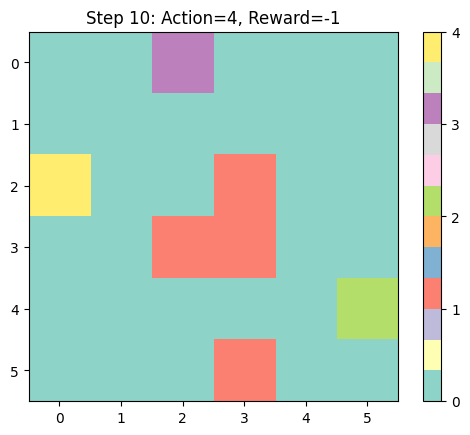

Eval Episode 1: Total Reward = -10


[-10]

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# ---------- Warehouse Environment ----------
class WarehouseEnv(gym.Env):
    def __init__(self, grid_size=(6, 6), deterministic=True, move_prob=0.9, num_items=1):
        super().__init__()
        self.grid_size = grid_size
        self.deterministic = deterministic
        self.move_prob = move_prob
        self.num_items = num_items
        self.action_space = spaces.Discrete(6)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(grid_size[0]),
            spaces.Discrete(grid_size[1]),
            spaces.Discrete(2)
        ))
        self.obstacles = {(3, 2), (2, 3), (3, 3), (5, 3)}
        self.drop_locations = [(0, 2)] * num_items
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        open_positions = [(x, y) for x in range(self.grid_size[0]) for y in range(self.grid_size[1])
                          if (x, y) not in self.obstacles and (x, y) not in [(0, 0), (0, 2)]]
        self.item_locations = random.sample(open_positions, self.num_items)
        self.robot_position = (0, 0)
        self.carrying_item = False
        self.current_item_index = 0
        self.done = False
        return self._get_state(), {}

    def step(self, action):
        if self.done:
            return self._get_state(), 0, True, False, {}
        reward = -1
        move_actions = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}
        if action in move_actions:
            new_pos = (self.robot_position[0] + move_actions[action][0],
                       self.robot_position[1] + move_actions[action][1])
            if self._is_valid(new_pos):
                if self.deterministic or random.random() < self.move_prob:
                    self.robot_position = new_pos
            else:
                reward = -20
        elif action == 4 and not self.carrying_item and self.robot_position == self.item_locations[self.current_item_index]:
            self.carrying_item = True
            reward = 25
        elif action == 5 and self.carrying_item and self.robot_position == self.drop_locations[self.current_item_index]:
            self.carrying_item = False
            reward = 100
            self.current_item_index += 1
            if self.current_item_index >= self.num_items:
                self.done = True
        return self._get_state(), reward, self.done, False, {}

    def _is_valid(self, pos):
        return 0 <= pos[0] < self.grid_size[0] and 0 <= pos[1] < self.grid_size[1] and pos not in self.obstacles

    def _get_state(self):
        return (*self.robot_position, int(self.carrying_item))

    def render(self, title="Warehouse Robot"):
        grid = np.zeros(self.grid_size)
        for obs in self.obstacles: grid[obs] = 1
        for item in self.item_locations: grid[item] = 2
        for drop in self.drop_locations: grid[drop] = 3
        grid[self.robot_position] = 4
        plt.clf()
        plt.imshow(grid, cmap="Set3", vmin=0, vmax=4)
        plt.title(title)
        plt.colorbar(ticks=[0, 1, 2, 3, 4])
        plt.pause(0.001)

# ---------- Q-Network ----------
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, action_dim))
    def forward(self, x):
        return self.fc(x)

# ---------- DQN Agent ----------
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.99):
        self.policy_net = QNetwork(state_dim, action_dim)
        self.target_net = QNetwork(state_dim, action_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.memory = deque(maxlen=500)
        self.batch_size = 32
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.state_dim = state_dim
        self.action_dim = action_dim

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad(): return self.policy_net(state).argmax().item()

    def remember(self, transition):
        self.memory.append(transition)

    def train(self):
        if len(self.memory) < self.batch_size: return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        q_values = self.policy_net(states).gather(1, actions)
        with torch.no_grad():
            next_q = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target_q = rewards + self.gamma * next_q * (1 - dones)
        loss = self.loss_fn(q_values, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

# ---------- Train ----------
def train_dqn(env, episodes=100, max_steps=50):
    agent = DQNAgent(state_dim=3, action_dim=env.action_space.n)
    rewards, epsilons = [], []

    for ep in range(episodes):
        state, _ = env.reset()
        state = np.array(state, dtype=np.float32)
        total_reward = 0
        for step in range(max_steps):
            action = agent.act(state)
            next_state, reward, done, _, _ = env.step(action)
            next_state = np.array(next_state, dtype=np.float32)
            agent.remember((state, action, reward, next_state, done))
            agent.train()
            state = next_state
            total_reward += reward
            if done: break
        agent.update_target()
        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)
        rewards.append(total_reward)
        epsilons.append(agent.epsilon)
        print(f"Ep {ep+1}: Reward={total_reward:.1f}, Eps={agent.epsilon:.3f}")
    torch.save(agent.policy_net.state_dict(), "warehouse_dqn.pth")
    return rewards, epsilons, agent

# ---------- Evaluate Multiple ----------
def evaluate(env, agent, episodes=100, max_steps=10, render=False):
    eval_rewards = []
    for ep in range(episodes):
        state, _ = env.reset()
        state = np.array(state, dtype=np.float32)
        total_reward = 0
        for step in range(max_steps):
            action = agent.policy_net(torch.FloatTensor(state).unsqueeze(0)).argmax().item()
            next_state, reward, done, _, _ = env.step(action)
            if render:
                print(f"Step {step+1}: State={tuple(state)}, Action={action}, Reward={reward}")
                env.render(title=f"Step {step+1}: Action={action}, Reward={reward}")
            total_reward += reward
            state = np.array(next_state, dtype=np.float32)
            if done: break
        eval_rewards.append(total_reward)
        print(f"Eval Episode {ep+1}: Total Reward = {total_reward}")
    return eval_rewards

# ---------- Plotting ----------
def plot_results(rewards, epsilons):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(rewards, label="Train Reward")
    plt.title("Training Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")

    plt.subplot(1, 2, 2)
    plt.plot(epsilons, label="Epsilon", color='tab:red')
    plt.title("Epsilon Decay")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.tight_layout()
    plt.show()

def plot_eval_rewards(eval_rewards):
    plt.figure(figsize=(6, 4))
    plt.plot(eval_rewards, marker='o', color='tab:green')
    plt.title("Evaluation Rewards per Episode")
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ---------- Run ----------
env = WarehouseEnv()
rewards, epsilons, agent = train_dqn(env, episodes=100)
plot_results(rewards, epsilons)

# Evaluate and plot
eval_rewards = evaluate(env, agent, episodes=100, render=False)
plot_eval_rewards(eval_rewards)

# Final visual walkthrough
print("\nFinal Visualized Evaluation:")
evaluate(env, agent, episodes=1, render=True)
